In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def pad_image(data, padding):
    if len(data.shape) < 3:
        data = np.lib.pad(data, ((padding, padding), (padding, padding)), 'reflect')
    else:
        data = np.lib.pad(data, ((padding, padding), (padding, padding), (0,0)), 'reflect')
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h, stride, ext):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    if not is_2d:
        im = np.lib.pad(im, ((ext, ext), (ext, ext), (0,0)), 'reflect')
    for i in range(ext,imgheight+ext,stride):
        for j in range(ext,imgwidth+ext,stride):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                #im_patch = im[j:j+w, i:i+h, :]
                im_patch = im[j-ext:j+w+ext, i-ext:i+h+ext, :]
            list_patches.append(im_patch)
    return list_patches

# Extract features for a given image
def extract_img_features(filename, stride):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size, stride, padding)
    X = np.asarray([img_patches[i] for i in range(len(img_patches))])
    return X



In [3]:
patch_size = 16
window_size = 72
padding = (window_size - patch_size) // 2
stride = 16

In [4]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels, stride):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,stride):
        for j in range(0,imgwidth,stride):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

In [5]:
from cnn_model import CnnModel
import keras.backend as K

# Load model from disk
model = CnnModel()
model.load('weights.h5')

Using Theano backend.
DEBUG: nvcc STDOUT nvcc warning : The 'compute_20', 'sm_20', and 'sm_21' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
mod.cu
   Creating library C:/Users/Dario/AppData/Local/Theano/compiledir_Windows-8.1-6.3.9600-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpze_o7eny/m91973e5c136ea49268a916ff971b7377.lib and object C:/Users/Dario/AppData/Local/Theano/compiledir_Windows-8.1-6.3.9600-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpze_o7eny/m91973e5c136ea49268a916ff971b7377.exp

Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)
C:\Anaconda3\lib\site-packages\theano\sandbox\cuda\__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


# Visualize image segmentation

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/Dario/AppData/Local/Theano/compiledir_Windows-8.1-6.3.9600-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpjrj90zoe/m9a6bd0eb5ed5c92e91261282fc495cb4.lib and object C:/Users/Dario/AppData/Local/Theano/compiledir_Windows-8.1-6.3.9600-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpjrj90zoe/m9a6bd0eb5ed5c92e91261282fc495cb4.exp



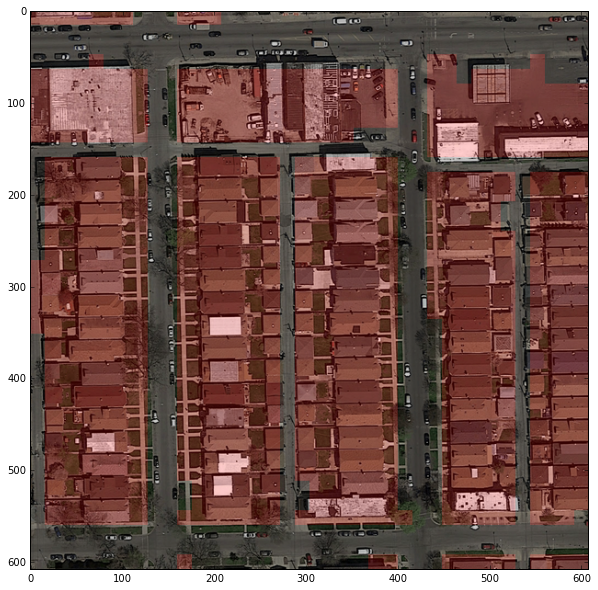

In [6]:
# Run prediction on the img_idx-th image (from the test set)
img_idx = 1 # This value can be changed

test_dir = "test_set_images/test_"
direc = test_dir + str(img_idx) + "/test_" + str(img_idx) + ".png"
Xi = extract_img_features(direc, stride)

# Ensure compatibility with both Theano and Tensorflow
if K.image_dim_ordering() == 'th':
    Xi = np.rollaxis(Xi, 3, 1)

Zi = model.model.predict(Xi)
Zi = Zi[:,0] > Zi[:,1]

img_ = load_image(direc)
w = img_.shape[0]
h = img_.shape[1]

predicted_im = label_to_img(w, h, patch_size, patch_size, Zi, stride)
cimg = concatenate_images(img_, predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(img_, predicted_im)
plt.imshow(new_img)

# Visualize convolution weights of the first layer

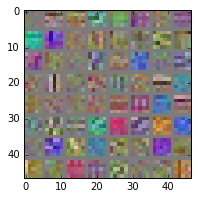

In [7]:
# Adapted from: https://gist.github.com/oeway/f0ed87d3df671b351b533108bf4d9d5d

from mpl_toolkits.axes_grid1 import make_axes_locatable
import pylab as pl

import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.zeros((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border, 3),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

def nice_imshow(ax, data, vmin=None, vmax=None):
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    data = (data - vmin)/(vmax-vmin) # Rescale data
    plt.imshow(data,interpolation='nearest')
    
# Visualize weights
W = model.model.layers[0].get_weights()[0]

# Compatibility with Theano and Tensorflow
if K.image_dim_ordering() == 'th':
    W = np.rollaxis(W, 1, 4)
else:
    W = np.rollaxis(W, 3)
    
pl.figure(figsize=(3, 3))
nice_imshow(pl.gca(), make_mosaic(W, int(np.sqrt(W.shape[0])), int(np.sqrt(W.shape[0]))))

# Visualize the images that maximally activate the filters

In [11]:
# Code adapted from Keras' example
# https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py

# This code has been tested only with Theano

from __future__ import print_function
from scipy.misc import imsave
import numpy as np
import time
from keras import backend as K

# dimensions of the generated pictures for each filter.
img_width = 72
img_height = 72

# the name of the layer we want to visualize
layer_name = 'leakyrelu_4'

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

model.model.summary()

# this is the placeholder for the input images
input_img = model.model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.model.layers[0:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


kept_filters = []
for filter_index in range(0, 256):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_dim_ordering() == 'th':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img, K.learning_phase()], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_dim_ordering() == 'th':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    
    # we run gradient ascent for 1000 steps
    for i in range(1000):
        loss_value, grads_value = iterate([input_img_data, 0])
        input_img_data += grads_value * step

    print('Current loss value:', loss_value)
    img = deprocess_image(input_img_data[0])
    kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 64, 72, 72)    4864        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 64, 72, 72)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 64, 36, 36)    0           leakyrelu_1[0][0]                
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 64, 36, 36)    0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/Dario/AppData/Local/Theano/compiledir_Windows-8.1-6.3.9600-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpjs1_d11t/m848dd898e26d545ff6290e3aa98de3d5.lib and object C:/Users/Dario/AppData/Local/Theano/compiledir_Windows-8.1-6.3.9600-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpjs1_d11t/m848dd898e26d545ff6290e3aa98de3d5.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/Dario/AppData/Local/Theano/compiledir_Windows-8.1-6.3.9600-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpnor68k4y/ma45c6c1ee6f9e22ef17ed999db1b0f13.lib and object C:/Users/Dario/AppData/Local/Theano/compiledir_Windows-8.1-6.3.9600-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpnor68k4y/ma45c6c1ee6f9e22ef17ed999db1b0f13.exp



Current loss value: 66253.8515625
Filter 0 processed in 12s
Processing filter 1
Current loss value: 99792.5546875
Filter 1 processed in 5s
Processing filter 2
Current loss value: 74433.4375
Filter 2 processed in 5s
Processing filter 3
Current loss value: 14360.015625
Filter 3 processed in 4s
Processing filter 4
Current loss value: 14568.6474609375
Filter 4 processed in 4s
Processing filter 5
Current loss value: 56996.24609375
Filter 5 processed in 5s
Processing filter 6
Current loss value: 245550.75
Filter 6 processed in 4s
Processing filter 7
Current loss value: 31863.68359375
Filter 7 processed in 5s
Processing filter 8
Current loss value: 138909.0
Filter 8 processed in 5s
Processing filter 9
Current loss value: 126332.6640625
Filter 9 processed in 4s
Processing filter 10
Current loss value: 223411.328125
Filter 10 processed in 4s
Processing filter 11
Current loss value: 41793.72265625
Filter 11 processed in 5s
Processing filter 12
Current loss value: 202418.125
Filter 12 processed i

256


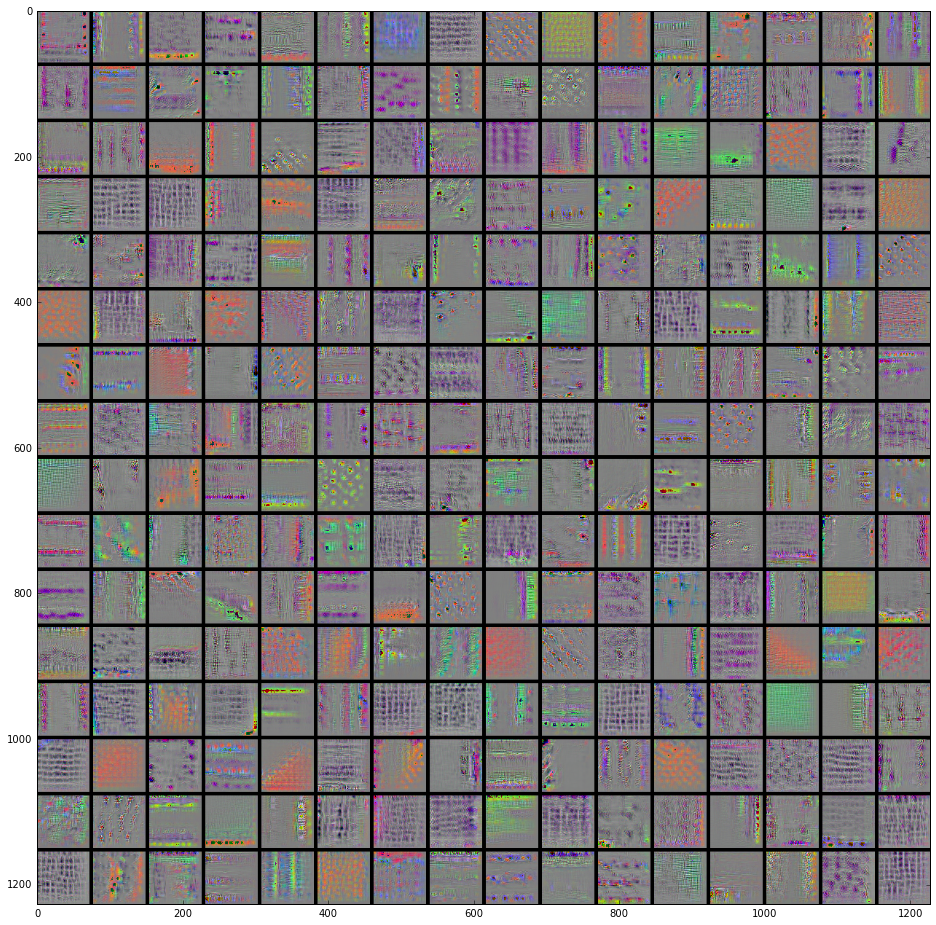

In [15]:
# we will stich all 256 filters on a 16 x 16 grid.
n = 16

# build a black picture with enough space for
# our 16 x 16 filters of size 72 x 72, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

print(len(kept_filters))
# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[(i * n + j) % len(kept_filters)]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)
plt.figure(figsize = (16,16))
plt.imshow(stitched_filters)